## Week 5 GANs (Monet)
### Import Packages

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from keras import backend as K

## Import Image Data

In [3]:
dir_monet = "/kaggle/input/gan-getting-started/monet_jpg/"
dir_photo = "/kaggle/input/gan-getting-started/photo_jpg/"
files_monet = os.listdir(dir_monet)
files_photo = os.listdir(dir_photo)

## Monet's Image

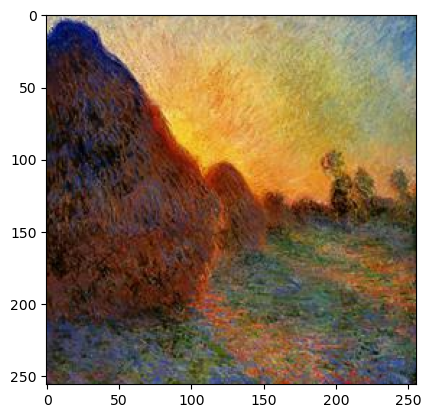

In [5]:
ID = 42
style_image0 = cv2.imread(dir_monet +  files_monet[ID])
plt.imshow(style_image0[:,:,::-1])

## Image to Convert

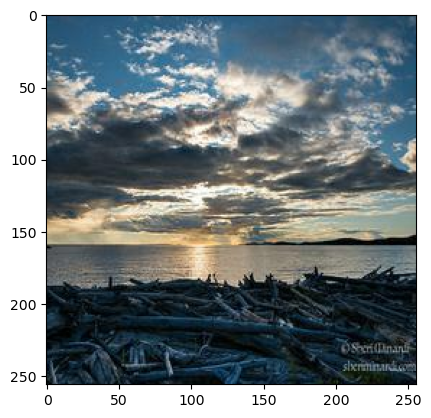

In [6]:
ID = 72
content_image0 = cv2.imread(dir_photo +  files_photo[ID])
plt.imshow(content_image0[:,:,::-1])

In [7]:
content_image0.shape

(256, 256, 3)

## Build Functions

In [8]:
def preprocess_image(image):
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)
    image = tf.reshape(image, shape = (1,256,256,3))
    return image

In [9]:
K.clear_session()
tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()
del tmp_vgg

574710816/574710816 [==============================] - 18s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [10]:
style_layers = ['block1_conv1', 
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ] 

layer_weights = [0.3, 0.7, 1.8, 1.8, 0.7]
content_layers = ['block5_conv4']
output_layers =  style_layers + content_layers

IM_count = len(content_layers)
MN_count = len(style_layers)

print(IM_count, MN_count)

1 5


In [11]:
def vgg_model(layer_names):
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(256,256,3))
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)  
    return model

In [12]:
# clear session to make layer naming consistent if re-running the cell
K.clear_session()

# create a vgg-19 model
vgg = vgg_model(output_layers)
vgg.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [13]:
def get_style_loss(features, targets):
    style_loss = tf.reduce_mean(tf.square(features - targets))
    return style_loss

def get_content_loss(features, targets):
    content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    return content_loss

def gram_matrix(input_tensor):
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 
    input_shape = tf.shape(input_tensor) 
    height = input_shape[1] 
    width = input_shape[2] 
    num_locations = tf.cast(height * width, tf.float32)
    scaled_gram = gram / num_locations
    return scaled_gram

In [14]:
def cal_style_loss(generated_image, style_image):
    v1 = vgg(generated_image)[:-1]
    v2 = vgg(style_image)[:-1]
    style_losses = []
    
    for i in range(5):
        style_loss = get_style_loss(v1[i], v2[i])
        style_losses.append(style_loss)

    return tf.add_n(style_losses)

In [15]:
def get_style_image_features(image):  
    outputs = vgg(image) 
    style_outputs = outputs[:NUM_STYLE_LAYERS] 
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] 
    return gram_style_features

In [16]:
def get_content_image_features(image):
    outputs = vgg(image) 
    content_outputs = outputs[NUM_STYLE_LAYERS:]
    return content_outputs

In [17]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
        
    style_losses = [ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)]
    
    for i in range(len(style_losses)):
        style_losses[i] =  style_losses[i]*layer_weights[i]
        
    style_loss = tf.add_n(style_losses)

    # Sum up the content losses
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

    # scale the style loss by multiplying by the style weight and dividing by the number of style layers
    style_loss = style_loss * style_weight / NUM_STYLE_LAYERS 
    
    sloss_list.append(style_loss)

    # scale the content loss by multiplying by the content weight and dividing by the number of content layers
    content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
    closs_list.append(content_loss)

    # sum up the style and content losses
    total_loss = style_loss + content_loss 

    return total_loss

In [18]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):

    with tf.GradientTape() as tape:

        style_features = get_style_image_features(image) 
        content_features = get_content_image_features(image) 
        loss = get_style_content_loss(style_targets, style_features, content_targets, content_features, style_weight, content_weight) 
        loss_list.append(loss)

    gradients = tape.gradient(loss, image) 

    return gradients

In [19]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
    
    gradients = calculate_gradients(image, style_targets, content_targets, style_weight, content_weight, var_weight) 
    optimizer.apply_gradients([(gradients, image)]) 
    image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [20]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

In [21]:
def convert_images(generated_image):
    img2 =  np.array(generated_image[0]).copy()
    img2 = img2[:,:,::-1]
    img2[:,:,0] = img2[:,:,0] + 127.5
    img2[:,:,1] = img2[:,:,1] + 127.5
    img2[:,:,2] = img2[:,:,2] + 127.5
    
    filter1 =  img2 < 0
    img2[filter1] = 0
    filter1 =  img2 > 255
    img2[filter1] = 255
    
    return img2.astype(int)[:,:,::-1]

In [22]:
style_weight=1e-2
content_weight=1e-17
var_weight=0

In [23]:
generated_image = preprocess_image(content_image0)
generated_image = tf.Variable(generated_image) 

In [24]:
content_image = preprocess_image(content_image0)
style_image =  preprocess_image(style_image0)

In [25]:
style_targets = get_style_image_features(style_image)
content_targets = get_content_image_features(content_image)

In [26]:
initial_image = convert_images(generated_image)

In [27]:
def plot_two(ITR):
    processed_image = convert_images(generated_image)
    
    fig, ax = plt.subplots(1, 2, figsize = (13, 6))
    ax[0].imshow(initial_image)
    ax[1].imshow(processed_image)
    ax[0].set_title("Original Image")
    ax[1].set_title("Style Transfer " + str(ITR) + " steps")

In [28]:
LR = 0.005
loss_list = []
closs_list = []
sloss_list = []

In [29]:
epoch = 100
for ITR in range(epoch):
    
    if ITR % 10 == 0:
        print(ITR)
    
    if ITR % 20 == 0:
        LR = LR*0.94
    gradients = calculate_gradients(generated_image, style_targets, content_targets, style_weight, content_weight, var_weight)    
    generated_image = generated_image - LR*gradients
    generated_image = tf.Variable(generated_image)     
    generated_image.assign(clip_image_values(generated_image, min_value=-127.5, max_value=127.5))

0
10
20
30
40
50
60
70
80
90


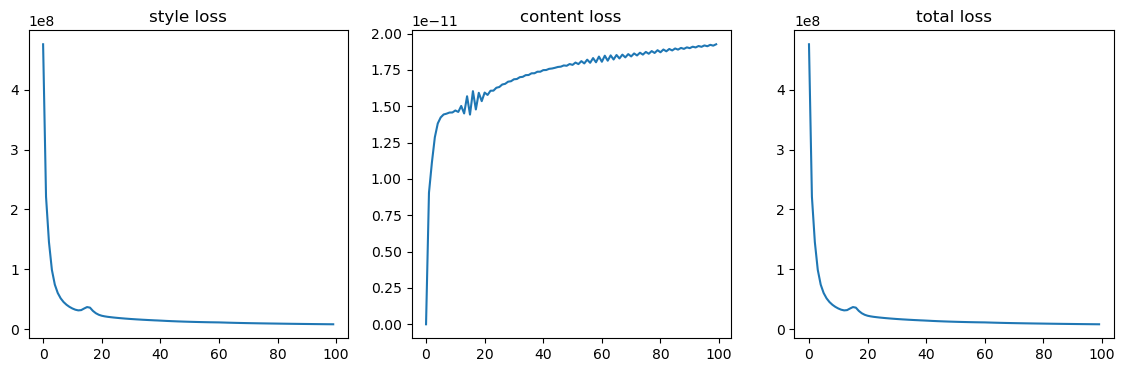

In [30]:
fig, ax = plt.subplots(1,3, figsize = (14,4))

ax[0].plot(sloss_list)
ax[1].plot(closs_list)
ax[2].plot(loss_list)

titles = ["style loss", "content loss", "total loss"]
for i in range(3):
    ax[i].set_title(titles[i])

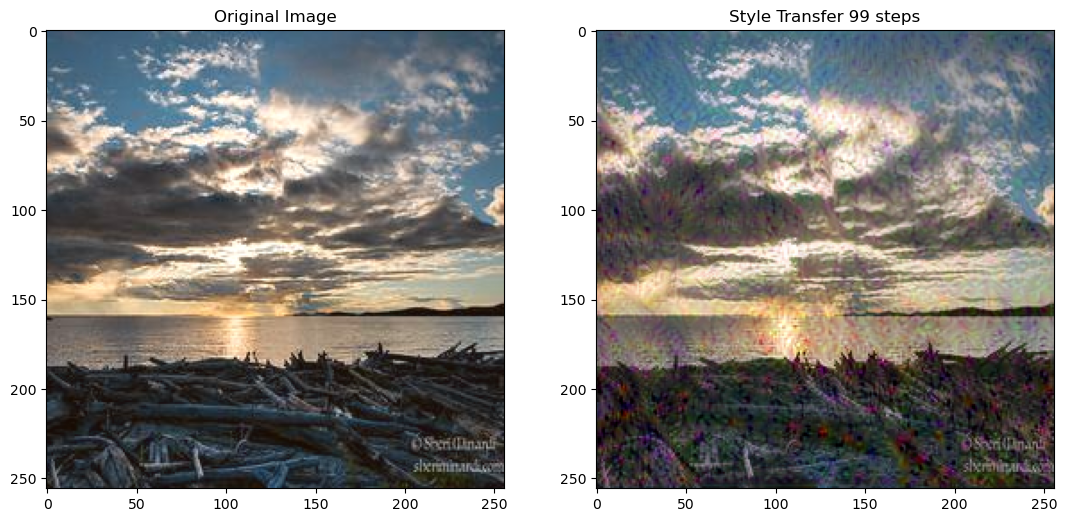

In [31]:
plot_two(ITR)

In [32]:
processed_image = convert_images(generated_image)

Text(0.5, 1.0, 'Style Transfer')

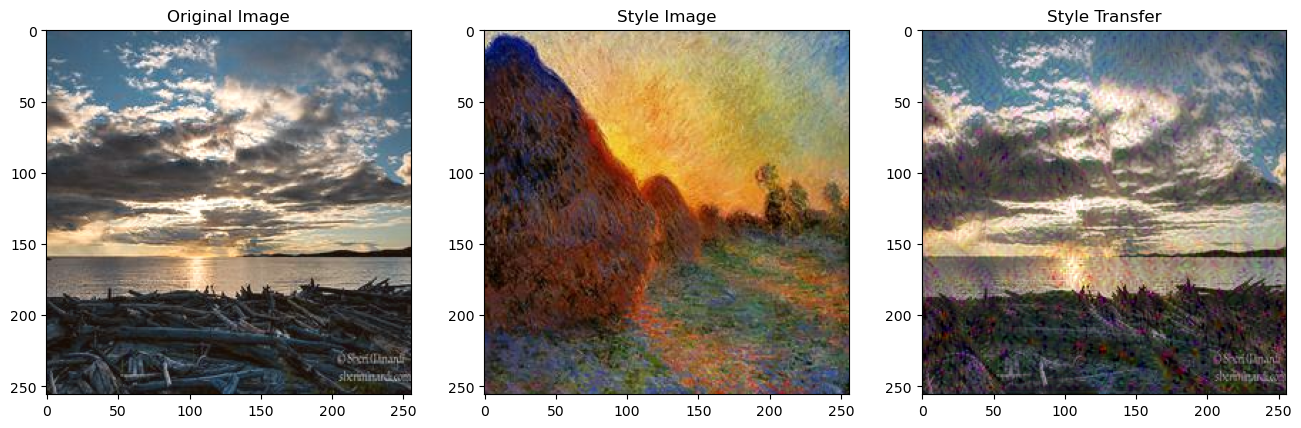

In [33]:
fig, ax = plt.subplots(1, 3, figsize = (16, 6))
ax[0].imshow(initial_image)
ax[1].imshow(style_image0[:,:,::-1])
ax[2].imshow(processed_image)
ax[0].set_title("Original Image")
ax[1].set_title("Style Image")
ax[2].set_title("Style Transfer")